In [1]:
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from ddm_utils import simulate_ddm, parse_sim_results
from joblib import Parallel, delayed
import pickle
from dynesty_utiils import loglike_fn, prior_transform

import matplotlib.pyplot as plt
import numpy as np


In [2]:
N_sim = 5000; v = 0.2; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(v, a) for _ in range(N_sim))


choices, RTs = parse_sim_results(sim_results)
    
with open('sample_rt.pkl', 'wb') as f:
    pickle.dump(RTs, f)
with open('sample_choice.pkl', 'wb') as f:
    pickle.dump(choices, f)

In [25]:
# save priors
# plb = np.array([-5,1,0.3]); pub = np.array([5,3,0.7])
priors_bounds = { 
    'v': [-5,5],
    'a': [1, 3],
    'w': [0.3, 0.7] 
}

# priors_bounds = { 
#     'v': [-1,1],
#     'a': [1, 3],
#     'w': [0.3, 0.7] 
# }

with open('dynesty_priors.pkl', 'wb') as f:
    pickle.dump(priors_bounds, f)

In [4]:
ndim = 3
sampler = NestedSampler(loglike_fn, prior_transform, ndim)

In [5]:
sampler.run_nested()

6320it [2:23:53,  1.37s/it, +500 | bound: 12 | nc: 1 | ncall: 27115 | eff(%): 25.625 | loglstar:   -inf < -7709.477 <    inf | logz: -7721.326 +/-  0.150 | dlogz:  0.001 >  0.509]


# multi processing nested samp

In [37]:
import multiprocessing
num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_processes)


In [39]:
ndim = 3
sampler = NestedSampler(loglike_fn, prior_transform, ndim, pool=pool, queue_size=num_processes)


In [40]:
# Run the sampler
sampler.run_nested()

# Close the pool
pool.close()
pool.join()

6997it [04:04, 28.60it/s, +500 | bound: 13 | nc: 1 | ncall: 27964 | eff(%): 27.298 | loglstar:   -inf < -7709.479 <    inf | logz: -7722.676 +/-  0.159 | dlogz:  0.001 >  0.509]


In [41]:
nested_samp_results = sampler.results

with open('nested_samp_results_parallel_long_prior.pkl', 'wb') as f:
    pickle.dump(nested_samp_results, f)



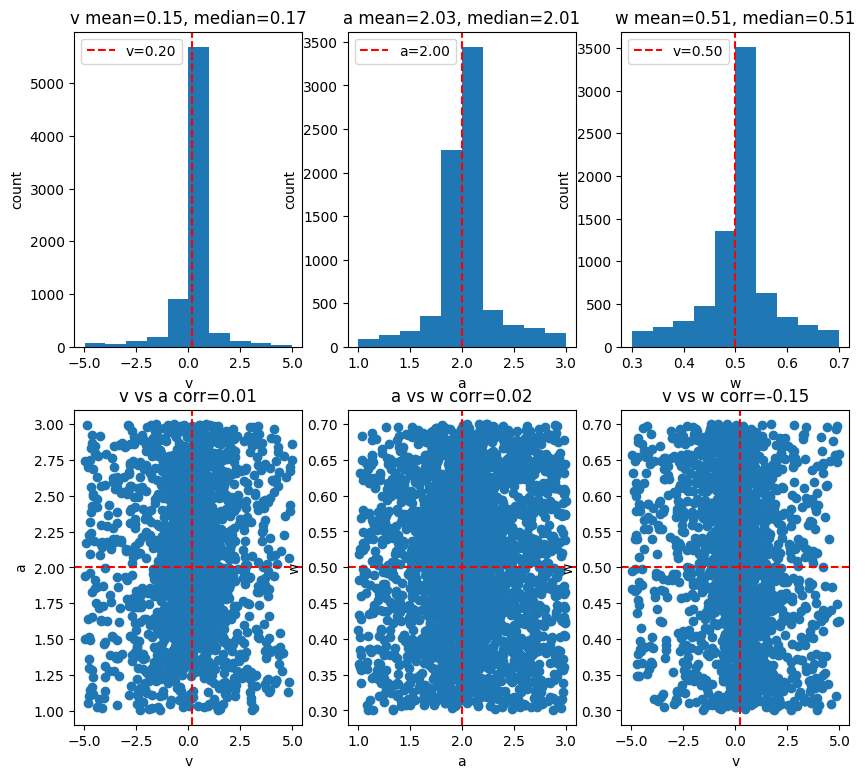

In [42]:
v_samp = nested_samp_results.samples[:,0]; a_samp = nested_samp_results.samples[:,1]; w_samp = nested_samp_results.samples[:,2]
true_v = 0.2; true_a = 2; true_w = 0.5

plt.figure(figsize=(10,9))
plt.subplot(2,3,1)
plt.hist(v_samp); plt.xlabel('v'); plt.ylabel('count'); plt.title(f'v mean={np.mean(v_samp):.2f}, median={np.median(v_samp):.2f}');
plt.axvline(x=true_v, color='r', linestyle='--', label=f'v={true_v:.2f}')
plt.legend()

plt.subplot(2,3,2)
plt.hist(a_samp); plt.xlabel('a'); plt.ylabel('count'); plt.title(f'a mean={np.mean(a_samp):.2f}, median={np.median(a_samp):.2f}');
plt.axvline(x=true_a, color='r', linestyle='--', label=f'a={true_a:.2f}')
plt.legend()

plt.subplot(2,3,3)
plt.hist(w_samp); plt.xlabel('w'); plt.ylabel('count'); plt.title(f'w mean={np.mean(w_samp):.2f}, median={np.median(w_samp):.2f}');
plt.axvline(x=true_w, color='r', linestyle='--', label=f'v={true_w:.2f}')
plt.legend()

plt.subplot(2,3,4)
plt.scatter(v_samp, a_samp); plt.xlabel('v'); plt.ylabel('a'); plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0,1]:.2f}');
plt.axvline(x=true_v, color='r', linestyle='--')
plt.axhline(y=true_a, color='r', linestyle='--')


plt.subplot(2,3,5)
plt.scatter(a_samp, w_samp); plt.xlabel('a'); plt.ylabel('w'); plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0,1]:.2f}');
plt.axvline(x=true_a, color='r', linestyle='--')
plt.axhline(y=true_w, color='r', linestyle='--')

plt.subplot(2,3,6)
plt.scatter(v_samp, w_samp); plt.xlabel('v'); plt.ylabel('w'); plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0,1]:.2f}');
plt.axvline(x=true_v, color='r', linestyle='--')
plt.axhline(y=true_w, color='r', linestyle='--')


# dynesty plots

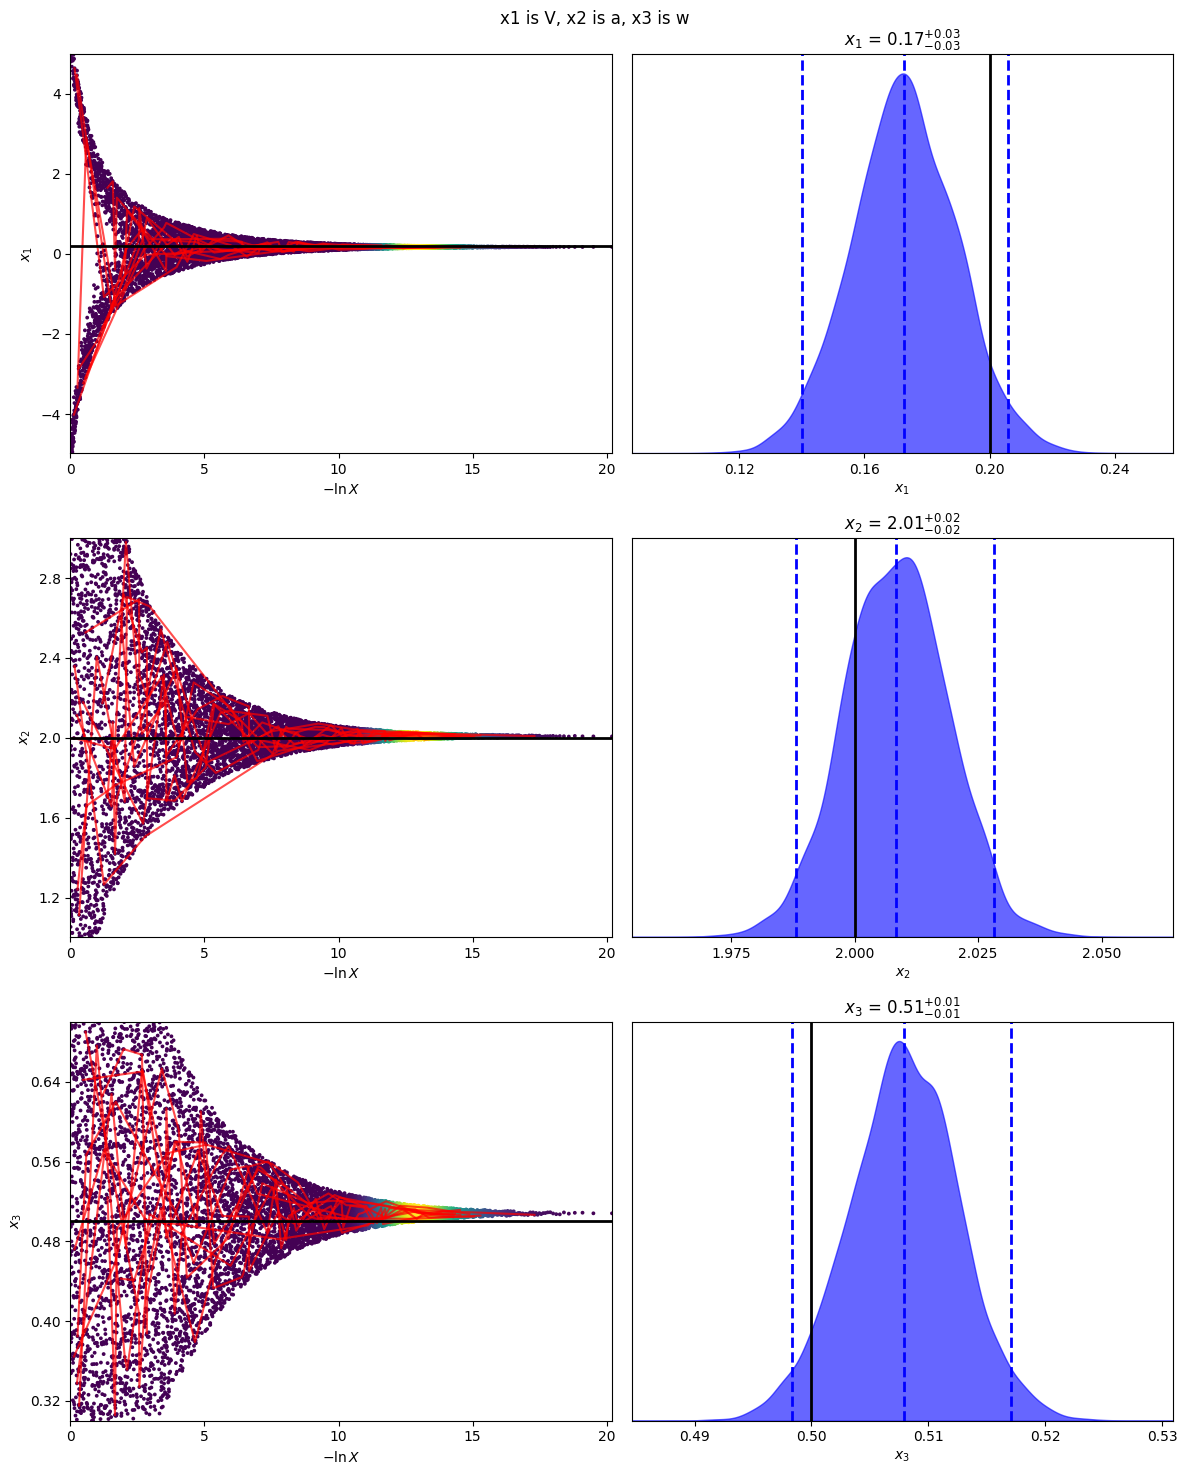

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig, axes = dyplot.traceplot(nested_samp_results, truths=np.array([true_v, true_a, true_w]),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             fig=(fig, axes))
fig.suptitle('x1 is V, x2 is a, x3 is w')
plt.tight_layout()


## Serial dynesty took 162 mins. Compare it with VBMC

In [25]:
from ex23_utils import run_vbmc, save_prior_bounds
from scipy import stats
import numpy as np
from pyvbmc import  VBMC
import pickle
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [3]:
prior_bounds = { 'v_low': -7, 'v_high': 7, 'a_low': 0.1, 'a_high': 5, 'w_low': 0.1, 'w_high': 0.9 }
save_prior_bounds(prior_bounds)

lb = np.array([-7, 0.1, 0.1]); ub = np.array([7, 5, 0.9])
plb = np.array([-5,1,0.3]); pub = np.array([5,3,0.7])

x0 = np.array([np.random.uniform(plb[0], pub[0]), np.random.uniform(plb[1], pub[1]), np.random.uniform(plb[2], pub[2])])
vp, results = run_vbmc(x0, lb, ub, plb, pub)

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7646.323 +/-0.000.


In [4]:
v_a_w, _ = vp.sample(int(3e5))
v_samp = v_a_w[:,0]; a_samp = v_a_w[:,1]; w_samp = v_a_w[:,2]

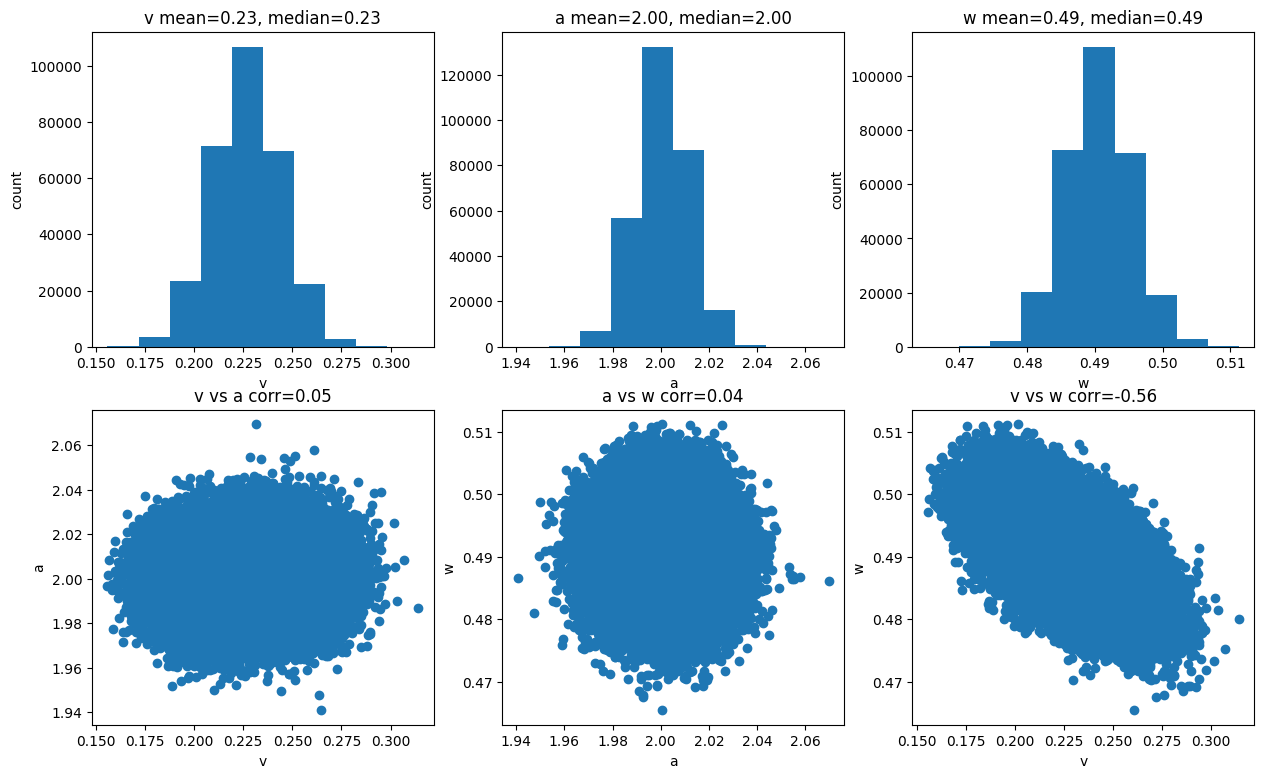

In [6]:
plt.figure(figsize=(15,9))
plt.subplot(2,3,1)
plt.hist(v_samp); plt.xlabel('v'); plt.ylabel('count'); plt.title(f'v mean={np.mean(v_samp):.2f}, median={np.median(v_samp):.2f}');
plt.subplot(2,3,2)
plt.hist(a_samp); plt.xlabel('a'); plt.ylabel('count'); plt.title(f'a mean={np.mean(a_samp):.2f}, median={np.median(a_samp):.2f}');
plt.subplot(2,3,3)
plt.hist(w_samp); plt.xlabel('w'); plt.ylabel('count'); plt.title(f'w mean={np.mean(w_samp):.2f}, median={np.median(w_samp):.2f}');

plt.subplot(2,3,4)
plt.scatter(v_samp, a_samp); plt.xlabel('v'); plt.ylabel('a'); plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0,1]:.2f}');
plt.subplot(2,3,5)
plt.scatter(a_samp, w_samp); plt.xlabel('a'); plt.ylabel('w'); plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0,1]:.2f}');
plt.subplot(2,3,6)
plt.scatter(v_samp, w_samp); plt.xlabel('v'); plt.ylabel('w'); plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0,1]:.2f}');

# Case 2

In [9]:
N_sim = 5000; v = 1.1; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(v, a) for _ in range(N_sim))


choices, RTs = parse_sim_results(sim_results)
    
with open('sample_rt.pkl', 'wb') as f:
    pickle.dump(RTs, f)
with open('sample_choice.pkl', 'wb') as f:
    pickle.dump(choices, f)

In [10]:
# save priors
# plb = np.array([-5,1,0.3]); pub = np.array([5,3,0.7])
priors_bounds = { 
    'v': [-5,5],
    'a': [1, 3],
    'w': [0.3, 0.7] 
}

with open('dynesty_priors.pkl', 'wb') as f:
    pickle.dump(priors_bounds, f)

In [11]:
import os
from multiprocessing import Pool

In [12]:
max_workers = os.cpu_count()

In [21]:
ndim = 3
sampler = NestedSampler(loglike_fn, prior_transform, ndim)

In [22]:
sampler.run_nested(maxiter=1000)

1001it [34:17,  4.94s/it, bound: 0 | nc: 21 | ncall: 3785 | eff(%): 26.446 | loglstar:   -inf < -6463.916 <    inf | logz: -6472.812 +/-  0.133 | dlogz: 2364.822 >  0.509] /home/rka/.local/lib/python3.10/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'
1001it [34:17,  2.06s/it, +500 | bound: 0 | nc: 1 | ncall: 4285 | eff(%): 39.657 | loglstar:   -inf < -4110.978 <    inf | logz: -4119.885 +/-  0.233 | dlogz:  1.097 >  0.509]


In [29]:
sampler.run_nested()

6941it [4:39:38,  2.42s/it, +500 | bound: 14 | nc: 1 | ncall: 28224 | eff(%): 26.840 | loglstar:   -inf < -4093.970 <    inf | logz: -4107.069 +/-  0.159 | dlogz:  0.001 >  0.509]


In [30]:
nested_samp_results = sampler.results

with open('nested_samp_results__3.pkl', 'wb') as f:
    pickle.dump(nested_samp_results, f)



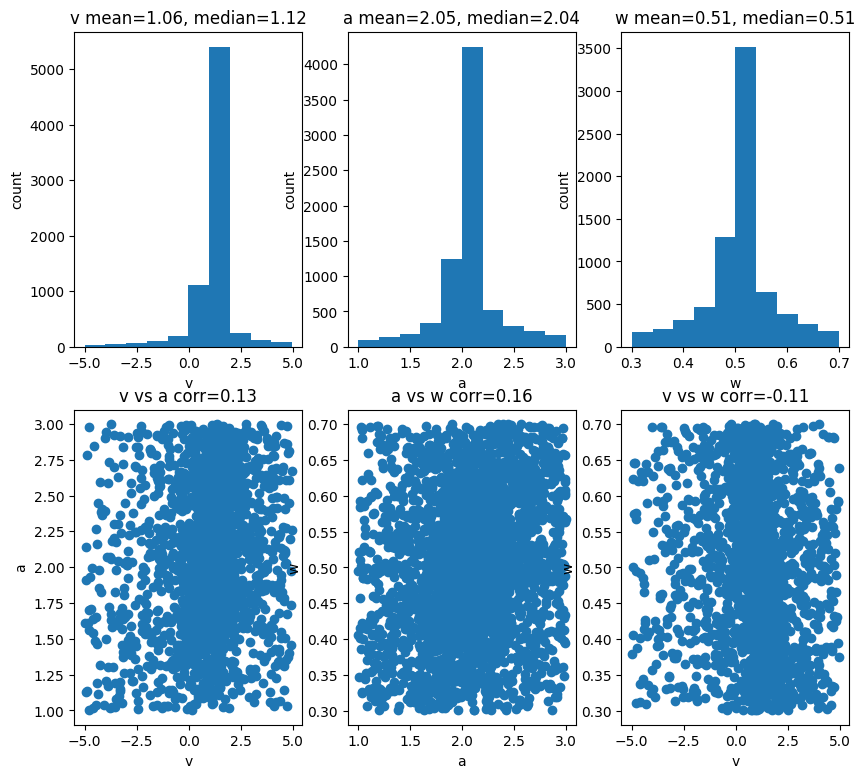

In [31]:
v_samp = nested_samp_results.samples[:,0]; a_samp = nested_samp_results.samples[:,1]; w_samp = nested_samp_results.samples[:,2]

plt.figure(figsize=(10,9))
plt.subplot(2,3,1)
plt.hist(v_samp); plt.xlabel('v'); plt.ylabel('count'); plt.title(f'v mean={np.mean(v_samp):.2f}, median={np.median(v_samp):.2f}');
plt.subplot(2,3,2)
plt.hist(a_samp); plt.xlabel('a'); plt.ylabel('count'); plt.title(f'a mean={np.mean(a_samp):.2f}, median={np.median(a_samp):.2f}');
plt.subplot(2,3,3)
plt.hist(w_samp); plt.xlabel('w'); plt.ylabel('count'); plt.title(f'w mean={np.mean(w_samp):.2f}, median={np.median(w_samp):.2f}');

plt.subplot(2,3,4)
plt.scatter(v_samp, a_samp); plt.xlabel('v'); plt.ylabel('a'); plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0,1]:.2f}');
plt.subplot(2,3,5)
plt.scatter(a_samp, w_samp); plt.xlabel('a'); plt.ylabel('w'); plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0,1]:.2f}');
plt.subplot(2,3,6)
plt.scatter(v_samp, w_samp); plt.xlabel('v'); plt.ylabel('w'); plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0,1]:.2f}');

# VBMC 2

In [26]:
prior_bounds = { 'v_low': -7, 'v_high': 7, 'a_low': 0.1, 'a_high': 5, 'w_low': 0.1, 'w_high': 0.9 }
save_prior_bounds(prior_bounds)

lb = np.array([-7, 0.1, 0.1]); ub = np.array([7, 5, 0.9])
plb = np.array([-5,1,0.3]); pub = np.array([5,3,0.7])

x0 = np.array([np.random.uniform(plb[0], pub[0]), np.random.uniform(plb[1], pub[1]), np.random.uniform(plb[2], pub[2])])
vp, results = run_vbmc(x0, lb, ub, plb, pub)

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4108.875 +/-0.001.


In [27]:
v_a_w, _ = vp.sample(int(3e5))
v_samp = v_a_w[:,0]; a_samp = v_a_w[:,1]; w_samp = v_a_w[:,2]

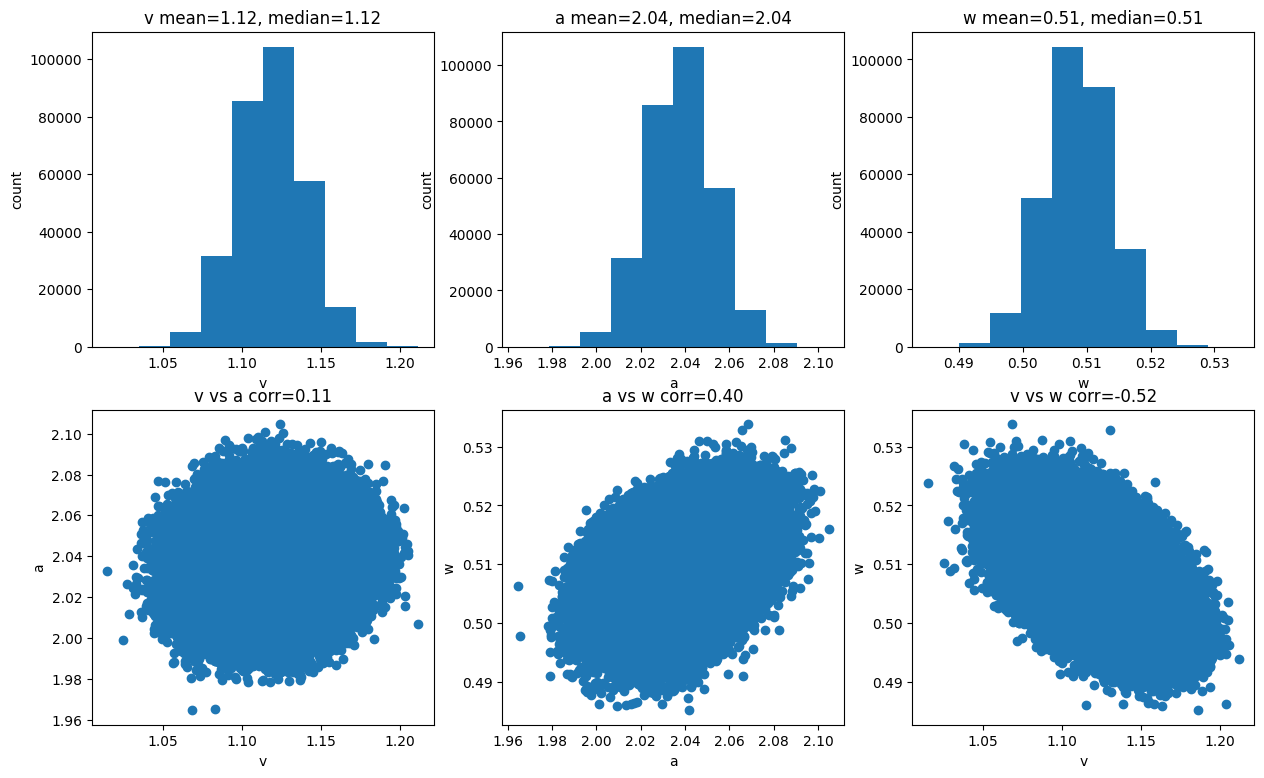

In [28]:
plt.figure(figsize=(15,9))
plt.subplot(2,3,1)
plt.hist(v_samp); plt.xlabel('v'); plt.ylabel('count'); plt.title(f'v mean={np.mean(v_samp):.2f}, median={np.median(v_samp):.2f}');
plt.subplot(2,3,2)
plt.hist(a_samp); plt.xlabel('a'); plt.ylabel('count'); plt.title(f'a mean={np.mean(a_samp):.2f}, median={np.median(a_samp):.2f}');
plt.subplot(2,3,3)
plt.hist(w_samp); plt.xlabel('w'); plt.ylabel('count'); plt.title(f'w mean={np.mean(w_samp):.2f}, median={np.median(w_samp):.2f}');

plt.subplot(2,3,4)
plt.scatter(v_samp, a_samp); plt.xlabel('v'); plt.ylabel('a'); plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0,1]:.2f}');
plt.subplot(2,3,5)
plt.scatter(a_samp, w_samp); plt.xlabel('a'); plt.ylabel('w'); plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0,1]:.2f}');
plt.subplot(2,3,6)
plt.scatter(v_samp, w_samp); plt.xlabel('v'); plt.ylabel('w'); plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0,1]:.2f}');